# Solar Data Discovery for Sierraleone Analysis Notebook

## Import the dependecies

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from windrose import WindroseAxes

## Import custom modules

In [2]:
# Add this at the top of your notebook to modify the Python path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Now you can import from src
# from src.visualizer import SolarVisualizer
from src.data_loader import DataLoader
from src.data_cleaner import DataCleaner
from src.analyzer import SolarAnalyzer
from src.data_visualizer import DataVisualizer

from src.utils import get_numeric_columns

## Load the Dataset

In [3]:
# Load the dataset
print("Loading dataset...")
df = DataLoader.load_csv('../data/raw/sierraleone-bumbuna.csv')

Loading dataset...


## 1. Summary Statistics & Missing-Value Report

In [4]:
# Overview of numeric columns
print("The description of the numeric columns:")
print(df.describe())
# Overview of the dataset
print("---------------------------------")
print("An overview of the dataset: the first 5 rows")
print(df.head())
# Overview of the dataset
print("----------------------------------")
print("An overview of the dataset: the last 5 rows")
print(df.tail())
# Overview of the dataset
print("----------------------------------")
print("An overview of the dataset: the shape of the dataset")
print(df.info())
# Check for missing values
print("----------------------------------")
print("Check for missing values:")
print(df.isna().sum())

The description of the numeric columns:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      201.957515     116.376337     113.720571     206.643095   
std       298.495150     218.652659     158.946032     300.896893   
min       -19.500000      -7.800000     -17.900000       0.000000   
25%        -2.800000      -0.300000      -3.800000       0.000000   
50%         0.300000      -0.100000      -0.100000       3.600000   
75%       362.400000     107.000000     224.700000     359.500000   
max      1499.000000     946.000000     892.000000    1507.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      198.114691      26.319394      79.448857       1.146113   
std       288.889073       4.398605      20.520775       1.239248   
min         0.000000      12.300000       9.900000       0.000

## 2. Outlier Detection & Basic Cleaning

In [5]:
# Clean negative values
solar_cols = ['GHI', 'DNI', 'DHI']

df = DataCleaner.clip_negative_values(df, solar_cols)

In [6]:
# Drop empty columns
if 'Comments' in df.columns:
    df = df.drop(columns=['Comments'])

In [7]:
# Handle outliers

numeric_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

df, outlier_count = DataCleaner.handle_outliers(df, numeric_cols, z_threshold=3)
print(f"Identified and handled {outlier_count} outliers")

Identified and handled 16547 outliers


In [8]:
# Export the cleaned dataset
DataLoader.export_to_csv(df, "../data/cleaned/sierraleone.csv")
print("Cleaned data saved to ../data/cleaned/sierraleone.csv")

Cleaned data saved to ../data/cleaned/sierraleone.csv


## 3. Time Series Analysis

In [9]:
# Convert timestamp and set as index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

In [10]:
# Create time-based features
df['Hour'] = df.index.hour
df['Month'] = df.index.month_name()

### 3.1 Daily Patterns Analysis

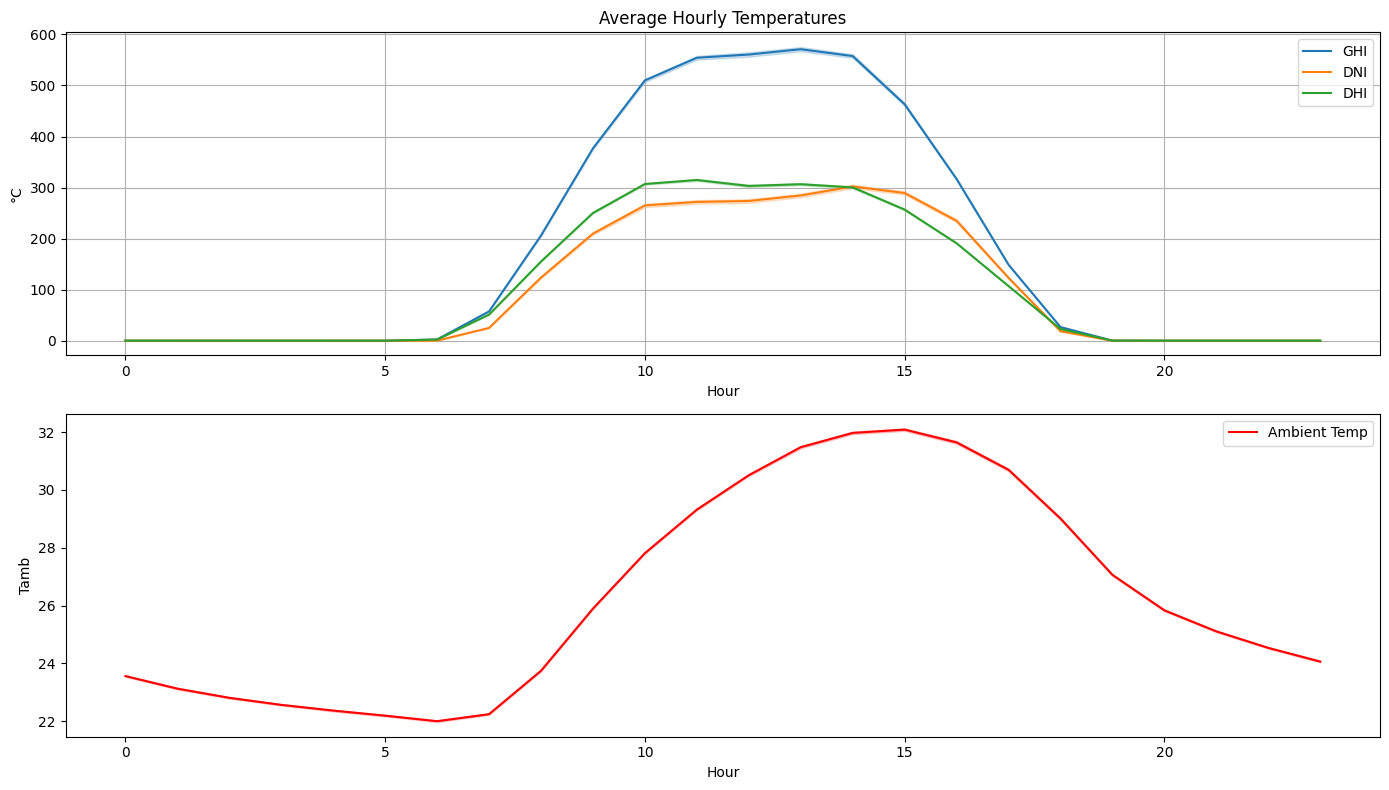

In [11]:
daily_fig = DataVisualizer.plot_daily_patterns(df)
plt.show()

### 3.2 Monthly Trends Analysis

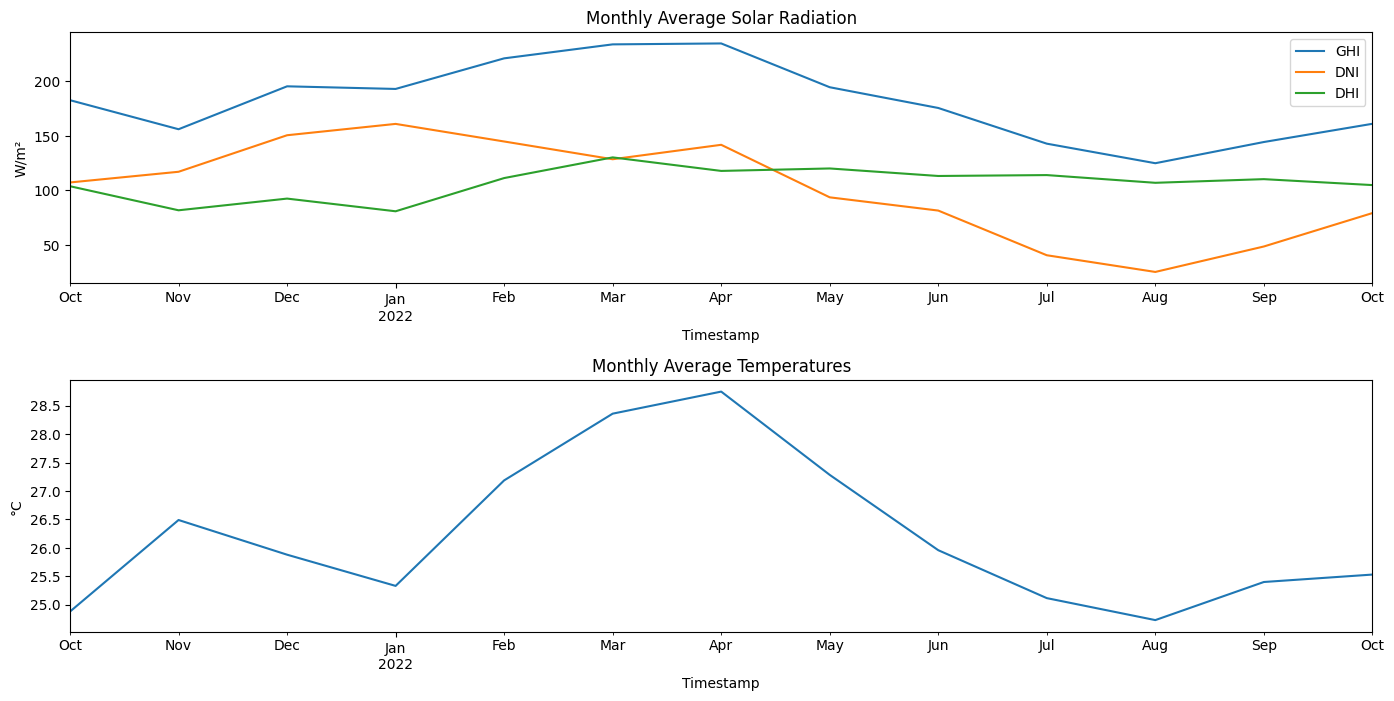

In [12]:
plt.figure(figsize=(14, 10))

# Monthly solar aggregation
plt.subplot(3,1,1)
df.resample('ME')['GHI','DNI','DHI'].mean().plot(ax=plt.gca())
plt.title('Monthly Average Solar Radiation')
plt.ylabel('W/m²')

# Temperature comparison
plt.subplot(3,1,2)
df.resample('ME')['Tamb'].mean().plot(ax=plt.gca())
plt.title('Monthly Average Temperatures')
plt.ylabel('°C')

plt.tight_layout()
plt.show()

## 4. Cleaning Impact

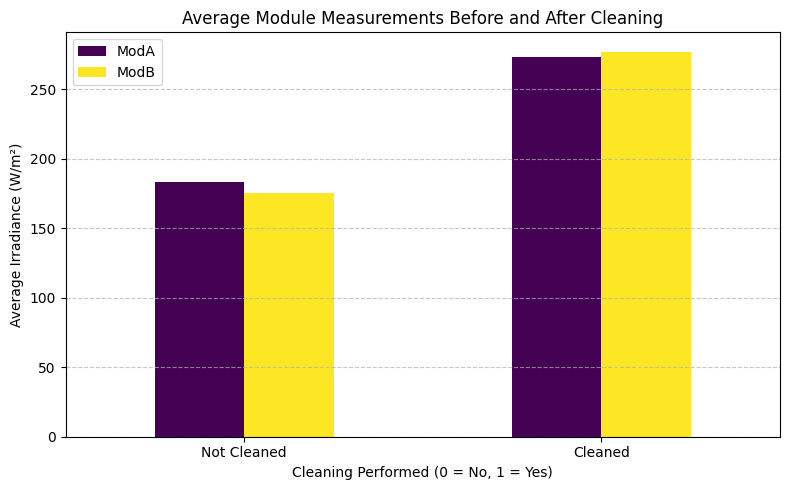

In [13]:
cleaning_impact, cleaning_fig = SolarAnalyzer.analyze_cleaning_impact(df)
plt.show()

## 5. Correlation & Relationship Analysis

### 5.1 Heatmap of correlations (GHI, DNI, DHI, TModA, TModB)

<Axes: >

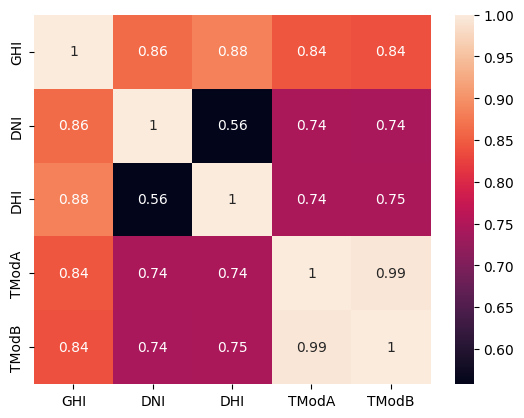

In [14]:
sns.heatmap(df[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr(), annot=True)

### 5.2 Scatter plot of WS, WSgust, WD vs. GHI

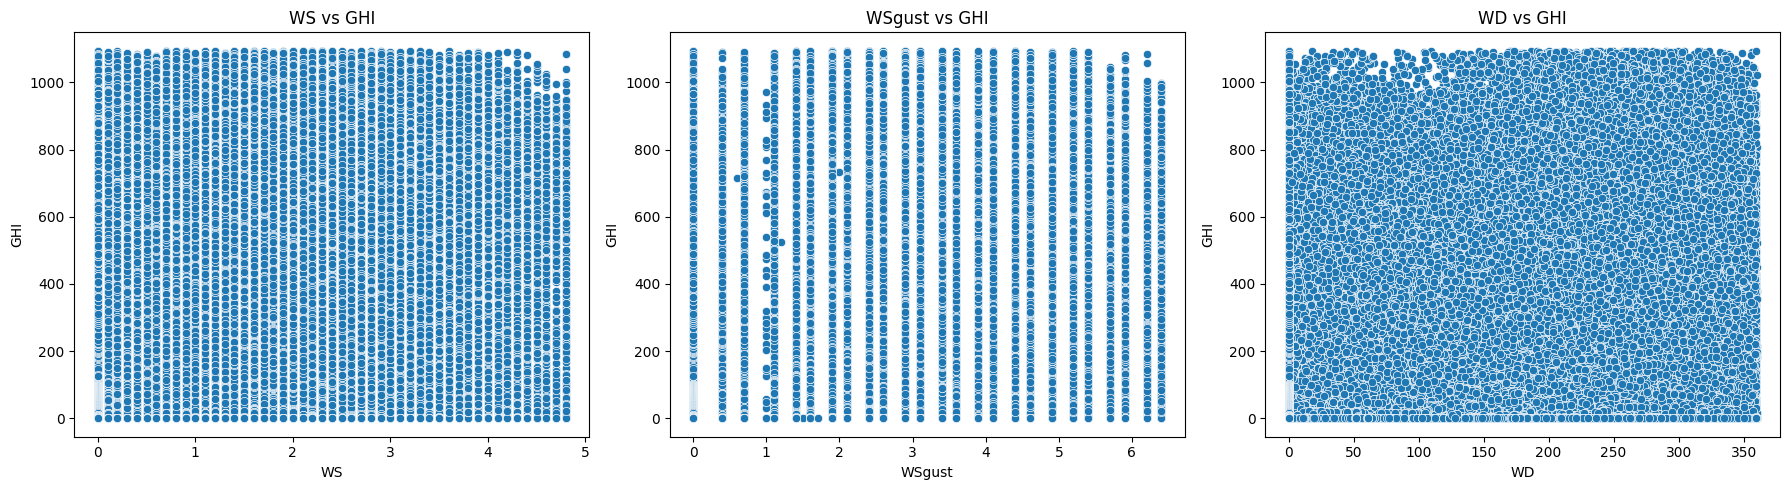

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=df, x='WS', y='GHI', ax=axs[0])
axs[0].set_title("WS vs GHI")

sns.scatterplot(data=df, x='WSgust', y='GHI', ax=axs[1])
axs[1].set_title("WSgust vs GHI")

sns.scatterplot(data=df, x='WD', y='GHI', ax=axs[2])
axs[2].set_title("WD vs GHI")

plt.tight_layout()
plt.show()


### 5.3 Scatter plot of RH vs. Tamb and RH vs. GHI

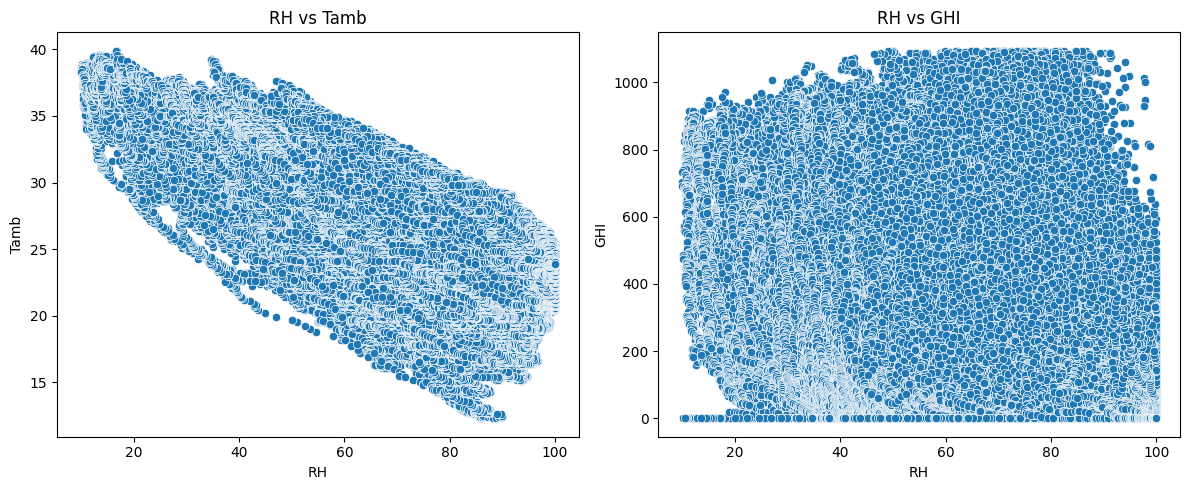

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(data=df, x='RH', y='Tamb', ax=axs[0])
axs[0].set_title("RH vs Tamb")

sns.scatterplot(data=df, x='RH', y='GHI', ax=axs[1])
axs[1].set_title("RH vs GHI")

plt.tight_layout()
plt.show()


# 6. Wind & Distribution Analysis

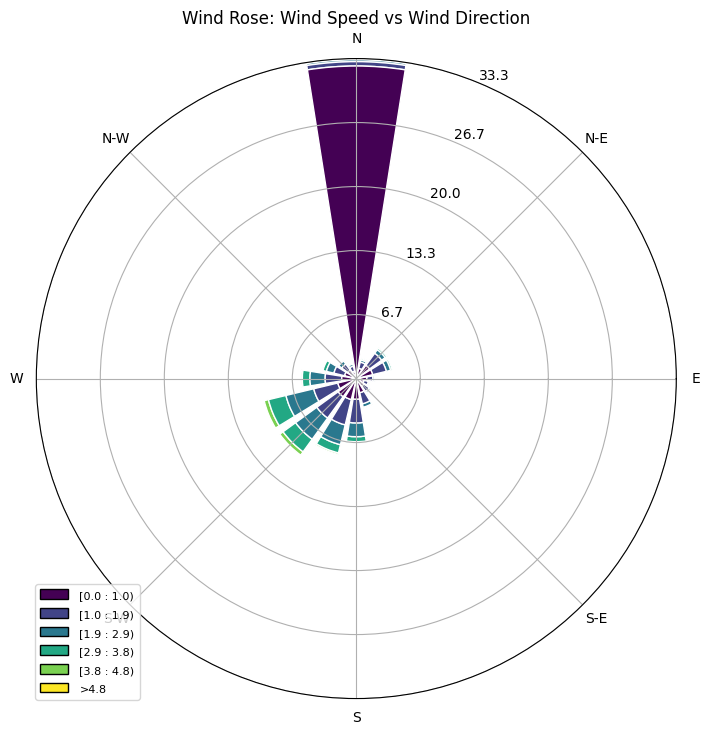

In [17]:
# Create windrose plot
wind_fig = DataVisualizer.plot_wind_rose(df)
plt.show()


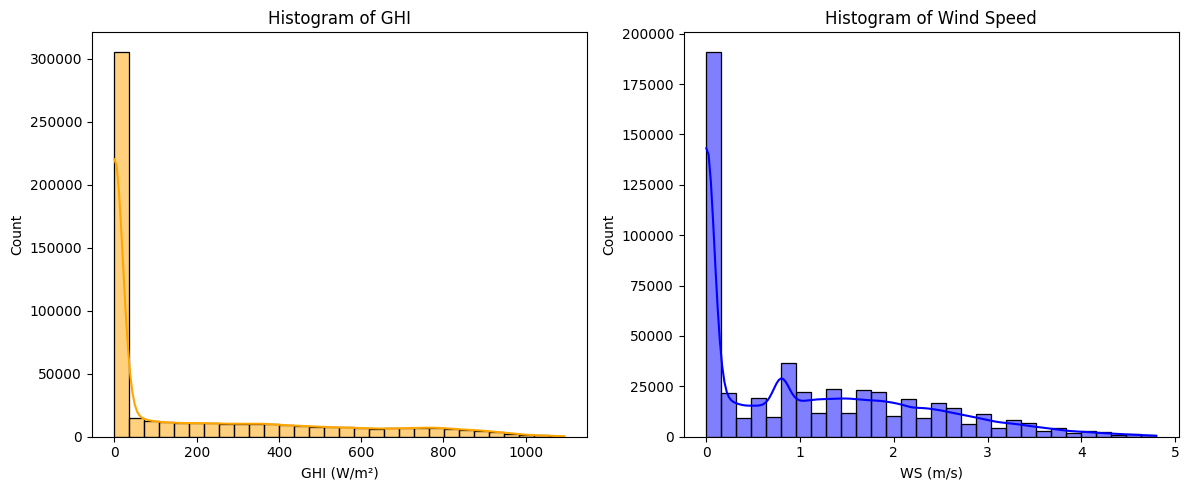

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for GHI
sns.histplot(df['GHI'], bins=30, kde=True, ax=axs[0], color='orange')
axs[0].set_title("Histogram of GHI")
axs[0].set_xlabel("GHI (W/m²)")

# Histogram for WS
sns.histplot(df['WS'], bins=30, kde=True, ax=axs[1], color='blue')
axs[1].set_title("Histogram of Wind Speed")
axs[1].set_xlabel("WS (m/s)")

plt.tight_layout()
plt.show()

## 7. Temperature Analysis

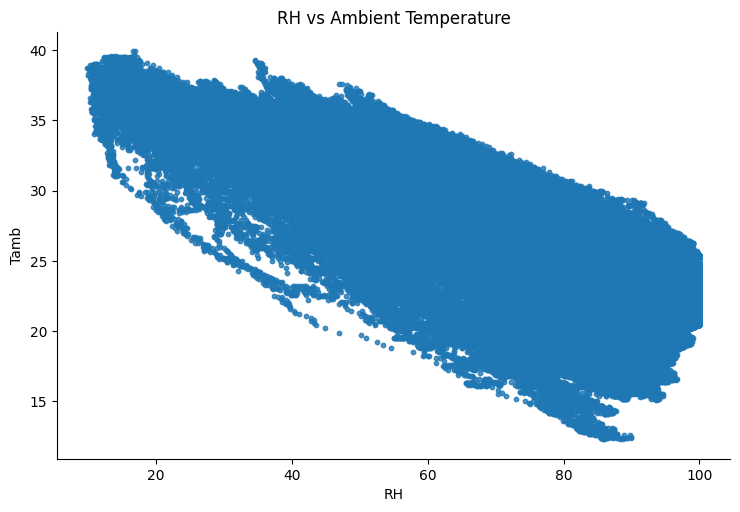

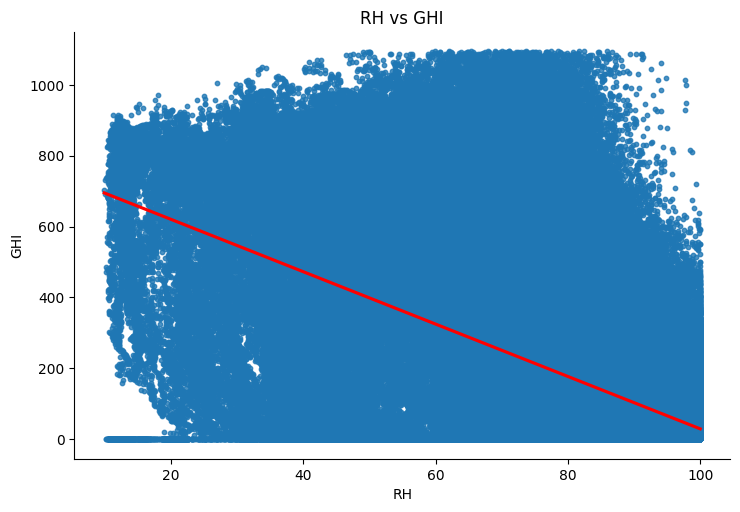

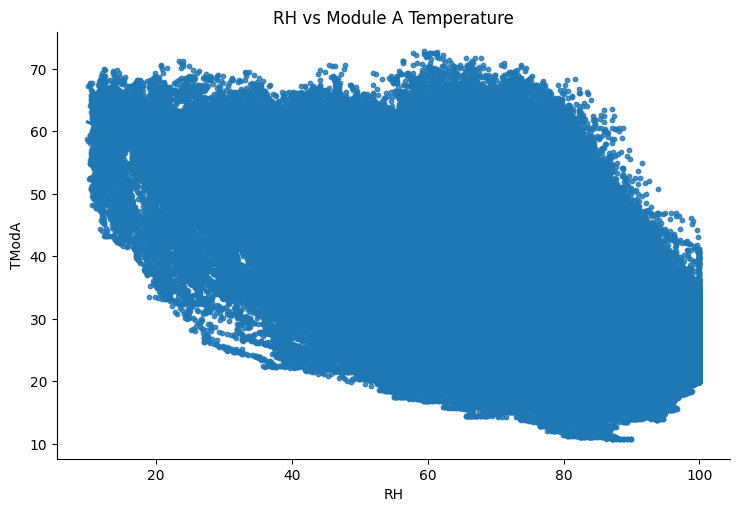

In [19]:
# how relative humidity (RH) might influence temperature readings and solar radiation

# RH vs Tamb
sns.lmplot(data=df, x='RH', y='Tamb', aspect=1.5, scatter_kws={"s": 10})
plt.title("RH vs Ambient Temperature")
plt.show()

# RH vs GHI
sns.lmplot(data=df, x='RH', y='GHI', aspect=1.5, scatter_kws={"s": 10}, line_kws={"color": "red"})
plt.title("RH vs GHI")
plt.show()

# RH vs TModA
sns.lmplot(data=df, x='RH', y='TModA', aspect=1.5, scatter_kws={"s": 10})
plt.title("RH vs Module A Temperature")
plt.show()

## 8. Bubble Chart

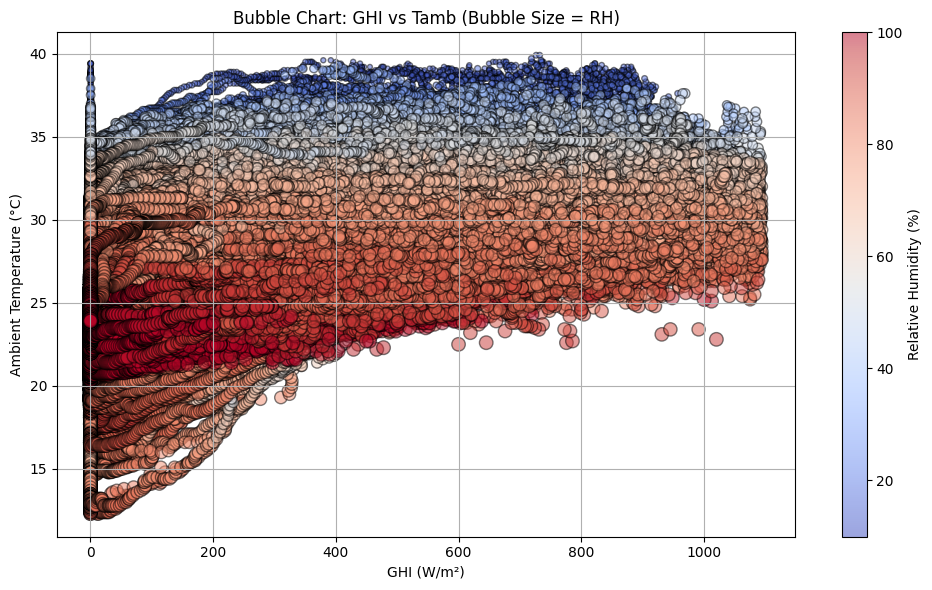

In [20]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df['GHI'],
    df['Tamb'],
    s=df['RH'],  # Bubble size
    alpha=0.5,
    c=df['RH'],
    cmap='coolwarm',
    edgecolors='k'
)
plt.colorbar(scatter, label='Relative Humidity (%)')
plt.xlabel('GHI (W/m²)')
plt.ylabel('Ambient Temperature (°C)')
plt.title('Bubble Chart: GHI vs Tamb (Bubble Size = RH)')
plt.grid(True)
plt.tight_layout()
plt.show()
